In [ ]:
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import tensorflow as tf
from   keras.models  import Model, Sequential, load_model
from   keras.layers  import Input, Dense, LSTM, Dropout, BatchNormalization
import keras.backend as K
from   keras         import optimizers as kopt
from   keras         import regularizers, callbacks

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from   scipy         import io, signal
from   numpy.linalg  import pinv as pinv
from   numpy.linalg  import inv  as inv

from   pathlib import Path

# !pip install bayesian-optimization
# from   bayesian-optimization     import BayesianOptimization

!pip install wget
import wget

# **The challenge**
Sara is an enthusiastic sportswoman and not in the least averse to particularly risky sports. The more adrenaline, the better. One of her friends, with whom Sara does all adventure sports together, recently had a serious sports accident and is paralysed from the cervical vertebrae downwards. 

This makes Sara realise the enormous risk of her sports. But since she doesn't want to miss out on the adrenaline rush, she wants to take preventive action. As an enthusiastic neuroscientist with a passion for Machine Learning and coding, she read an article about brain prostheses. With them, you can, for example, use your [thoughts to move a robotic arm](https://www.youtube.com/watch?v=BxHxXQPxBTQ&t=1s&ab_channel=WallStreetJournal).  Therefore, came up with the idea of developing a basic brain machine interface herself.  

After some research, Sara learned that you basically need two elements to be able to control an artificial arm:

*   A recording of the brain waves while performing certain movements with your arm;
*   At the same time, the muscle activities have to be measured.

Then one can deduce which brain waves lead to which arm movements. Luckily, one of her friends works in a neuroscience research lab and can conduct a few with her as a test subject and install the appropriate technical equipment in her brain and arm muscles. 

**Long story short**, Sara has four training sessions. In each session she has to grasp an object with her hand and 96 electrodes measure her brain waves and one of eight electrodes measures the activity of an arm muscle. 

The muscles used in these sessions are:
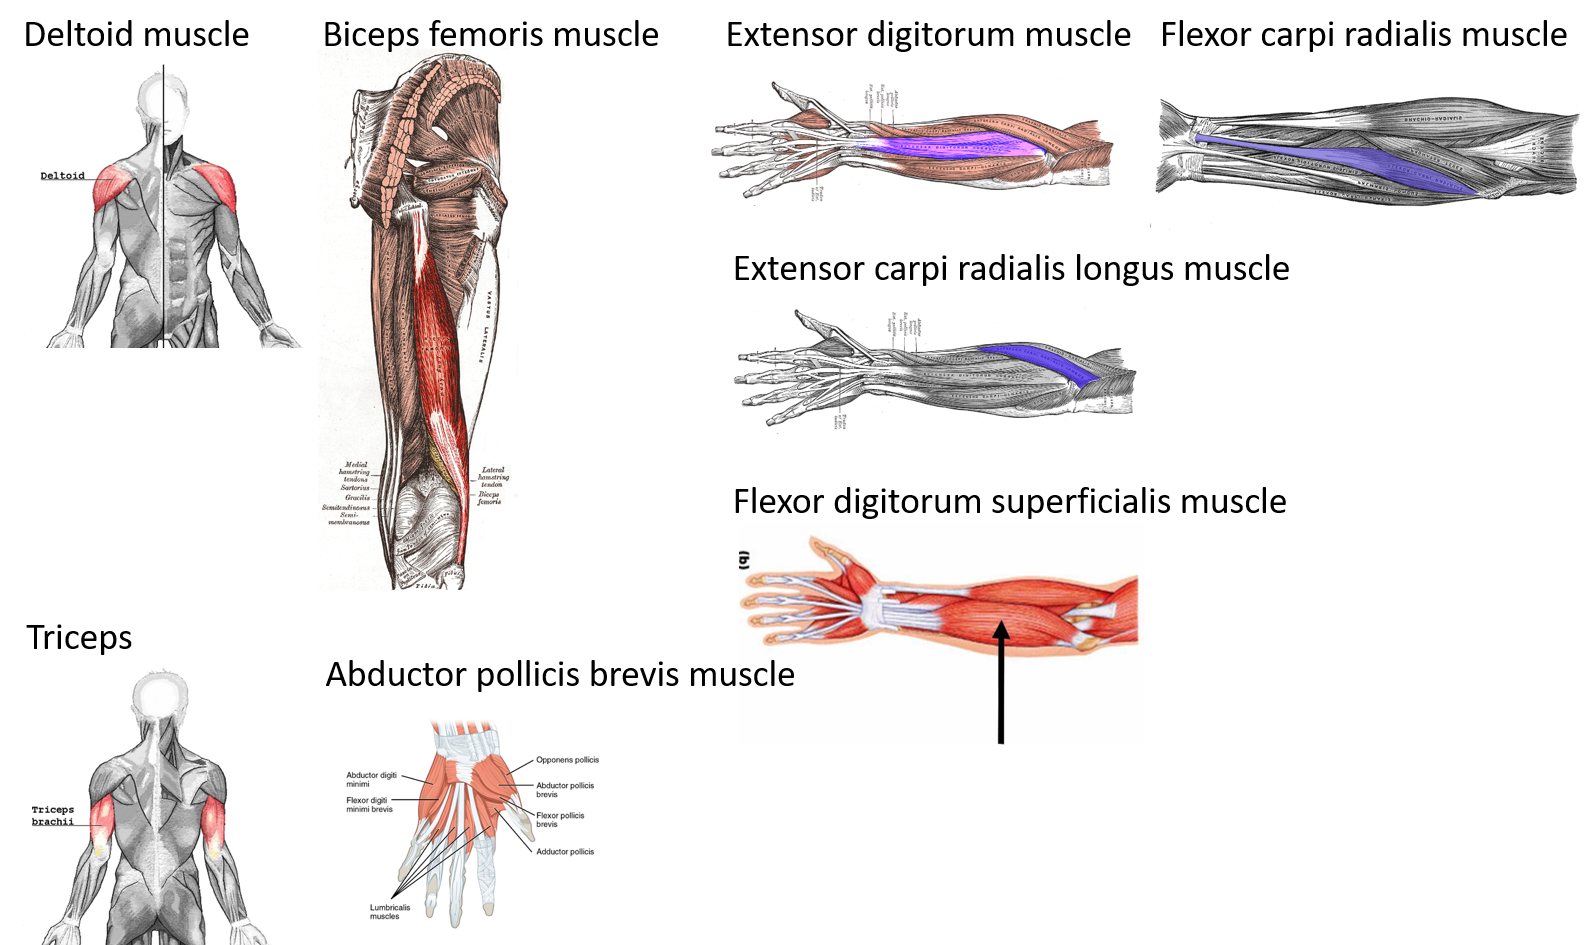

Afterwards, Sara can start analysing her recorded data and train, test and validate a decoder and optimise its parameters. With this decoder, it should then be possible to record only brain waves and predict the activity of her muscles, which can then be used to specifically control a prosthetic arm. 


In principle, Sara works on that problem with two different approaches:  worked on the problem twice. Once by means of an **LSTM decoder** (here everything is programmed by herself to a certain degree), and by means of an **RNN** (here Sara relies more on Keras, Tensorflow, and ready-to-use modules). 

# Get the Data
Sara first loads her data set. She sees that her muscle data is stored in a nested list (**EMGr**). Each element of this list contains the data of the eight muscles of one of the four training sessions of different durations. 



In [ ]:
def load_data(only_baseline = True):
    
    '''Four reaching training sessions'''
    
    # raw=true is important so you download the file rather than the webpage.
    !wget https://github.com/christopherhitz/decoderproject/blob/main/src/data/trial_data_0411.mat?raw=true
    
    # Load the data
    from scipy import io
    !mv trial_data_0411.mat\?raw\=true trial_data_0411.mat
    from scipy import io
    f = io.loadmat('trial_data_0411.mat')
     
    #Separate different data and adjust their size
    emg         = np.squeeze(f['emg'])
    
    spike_times = np.squeeze(f['spike_times'])
    for i in range(spike_times.shape[0]):
        spike_times[i] = np.squeeze(spike_times[i])
        
    electrode   = np.squeeze(f['electrode'])
    for i in range(electrode.shape[0]):
        electrode[i] = np.squeeze(electrode[i])
        
    fs_tdt      = np.squeeze(f['fs_tdt'])
    fs_neuron   = np.squeeze(f['fs_neuron'])
    
    T           = np.squeeze(f['T'])
    for i in range(T.shape[0]):
        T[i] = np.squeeze(T[i])
        
    labels      = np.squeeze(f['labels'])
    for i in range(labels.shape[0]):
        labels[i] = np.squeeze(labels[i])
        
    base_trials = int(f['base_trials'])
    

        
    return f, emg, spike_times, electrode, fs_tdt, fs_neuron, T, labels, base_trials

In [ ]:
f, EMGr, spike_times, electrode, fs_tdt, fs_neuron, T, labels, base_trials= load_data()

--2021-04-29 11:16:10--  https://github.com/christopherhitz/decoderproject/blob/main/src/data/trial_data_0411.mat?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/christopherhitz/decoderproject/raw/main/src/data/trial_data_0411.mat [following]
--2021-04-29 11:16:10--  https://github.com/christopherhitz/decoderproject/raw/main/src/data/trial_data_0411.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/christopherhitz/decoderproject/main/src/data/trial_data_0411.mat [following]
--2021-04-29 11:16:10--  https://raw.githubusercontent.com/christopherhitz/decoderproject/main/src/data/trial_data_0411.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.gi

# Discover and Visualize the Data to Gain Insights
Some figures to get a broad overview over the data would be interesting for Sara. She decides to use Pythons' basic plotting library Matplotlib to visualize the muscle activity of training session one.

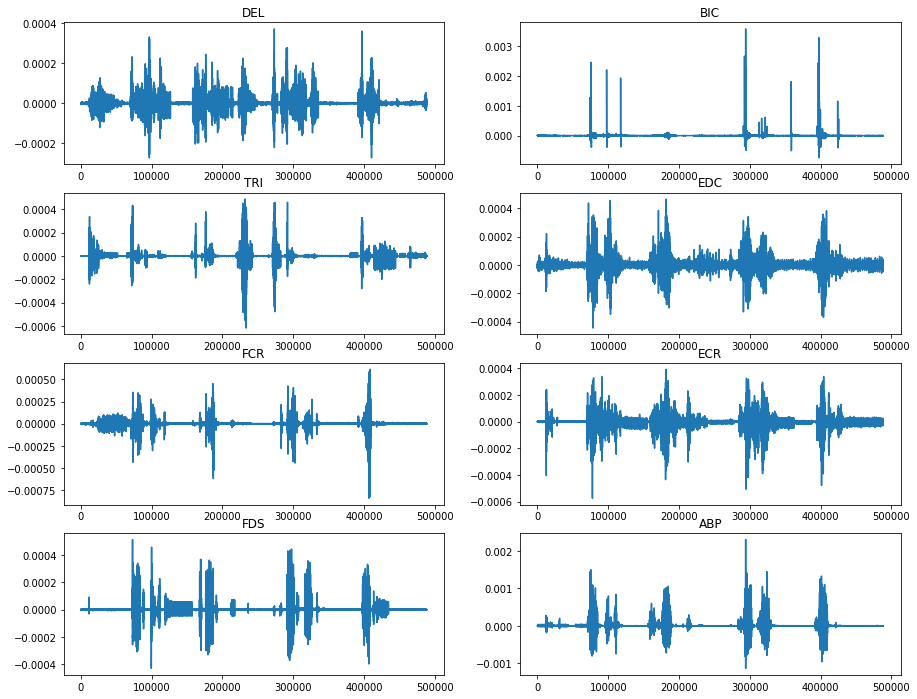

In [ ]:
plt.figure(figsize=(15,12))
for m in range(EMGr[1].shape[1]):
        plt.subplot(4,2,m+1)
        plt.plot(EMGr[0][:,m])
        plt.title(str(labels[m]))
plt.rcParams.update({'font.size': 10})

But this can be done a bit better. She converts the data into a Pandas DataFrame structure and plots directly from there. Additionally, she got some nice colours on the go. 

In [ ]:
for i in range(len(EMGr)):
    x   = EMGr[i]
df = pd.DataFrame(data=x, columns=([str(labels[0]), str(labels[1]), str(labels[2]), str(labels[3]), str(labels[4]), str(labels[5]), str(labels[6]), str(labels[7])]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0282d53d0>,
      dtype=object)

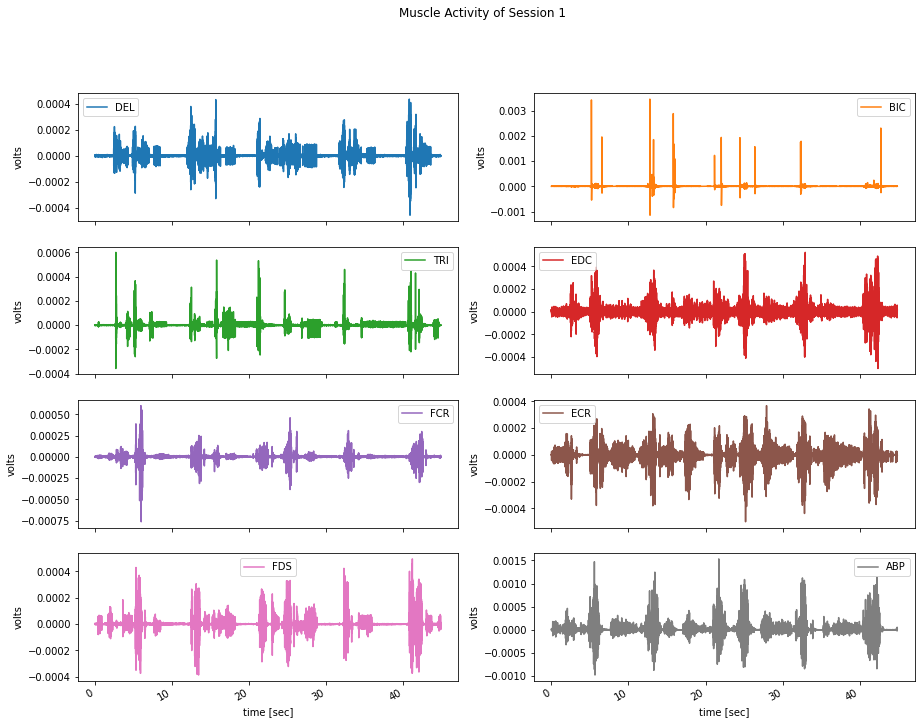

In [ ]:
df['time'] = df.index / fs_tdt
df = df.set_index(['time'])
df.plot(kind='line', subplots=True, layout=(4,2), figsize=(15,12), 
        use_index=True, title='Muscle Activity of Session 1',
        legend=True, xlabel='time [sec]', ylabel='volts', fontsize=10)

But clearly, interactivity is missing. She has to read of all y-values on her own. Therefore, she wants to use the Plotly library to have mouse hover over effects, and other possibilities like zooming into a specific data range, or the option to save the graph as a PNG file. Since her Colab Notebook crashes here, she decides to continue with the next important steps. 

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#df.reset_index(drop=False)

# fig = make_subplots(rows=4, cols=2,subplot_titles=(df.columns))

# fig.add_trace(go.Scatter( y=df['DEL'], mode='lines'),
#               row=1, col=1)

# fig.add_trace(go.Scatter( y=df['BIC'], mode='lines'),
#               row=1, col=2)

# fig.add_trace(go.Scatter( y=df['TRI'], mode='lines'),
#               row=2, col=1)

# fig.add_trace(go.Scatter( y=df['EDC'], mode='lines'),
#               row=2, col=2)

# fig.add_trace(go.Scatter( y=df['FCR'], mode='lines'),
#               row=3, col=1)

# fig.add_trace(go.Scatter( y=df['ECR'], mode='lines'),
#               row=3, col=2)

# fig.add_trace(go.Scatter( y=df['FDS'], mode='lines'),
#               row=4, col=1)

# fig.add_trace(go.Scatter( y=df['ABP'], mode='lines'),
#               row=4, col=2)

# fig.update_layout(#height=500, width=700,
#                   title_text="Muscle Activity of Session 1")

# fig.show()

Next, Sara explores the neuronal activity of her brain recordings for the first of four training sessions. From the recording she gets the frames in which the neurons have been very active, and thus were sending signals from the brain to the muscles. Since these arrays consist only of timestamps, where very high nerve cell activities have been recorded, there is no need to plot them.

# Prepare the Data for Machine Learning Algorithmns, Neural Networks and Deep Learning

Since Sara are working with real data and not with perfectly prepared data sets, some specific corrections for neuronal and electromyographic data are necessary. In order to be able to apply these procedures to a variety of data, Sara writes them in the form of reusable functions.  

First of all, Sara knows from experience in which value range muscular signals have to fall. As a result, she can identify measurement errors and outliers, for example by means of threshold values, and then impute them.  

#### Filter the muscle signals for outliers

Therefore she decides to filter the muscle signals with a basic threshold filter to remove noise peaks: Outliers are regarded as values which are higher then the mean value of the muscle activity plus a noise threshold value times the muscles standard deviation. Outliers are then replaced by zeros.

In [ ]:
bin_size = 0.05 #In seconds
overlap  = 0.03 #In seconds
EMGbin   = []
FRmat    = []

def filt_EMG(emg, noise_th = 2, h_win_l = 1, filt_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]):
    """
    Function that filters the emg to remove the noise peaks
    
    Inputs
    -------
    emg      : The signal to be filtered (time on rows and muscles on columns)
    noise_th : The threshold (multiplied by the std) above which the signal is 
               considered noise. Default is 2
    h_win_l  : Half of the length of the window of the zeroed signal around the 
               noise. Default is 1
    filt_ind : index of the muscles to be filtered. Default are shoulder,biceps
               and triceps
    
    Output
    -------
    EMGf : the filtered EMG (time on rows and muscles on columns)
    """
    EMGf = np.copy(emg)
    
    for c in filt_ind:
        #Check for the instants in which the threshold is passed
        r_index = np.where(abs(emg[:,c]) > np.mean(abs(emg[:,c])) + noise_th*np.std(abs(emg[:,c])))
        #Go to the next muscle if there is no threshold passing
        if not r_index[0].size > 0:
            continue
        #Substitute noise values with 0
        for r in r_index[0]:
            if r >= h_win_l and r+h_win_l < EMGf.shape[0]:
                EMGf[r-h_win_l:r+h_win_l+1,c] = 0
            elif r < h_win_l:
                EMGf[0:r+h_win_l+1,c] = 0
            elif r+h_win_l >= EMGf.shape[0]:
                EMGf[r-h_win_l:-1,c] = 0
#    EMGf = emg            
    return EMGf

#### Impute missing values in the muscle signals
In theory, there can be gaps in the muscle data. Therefore, Sara uses a median imputer.

In [ ]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median'))])


#### Create the envelope of the muscle activity
Moreover, Sara knows that it is not the detailed trace of the muscular signals that is important. Rather, it is quite sufficient to calculate the envelope of the detailed trace, so that one can speak more of wave pulses. 

In [ ]:
#################################EMG ENVELOPE##################################
def env_EMG(emg, fs):
    """
    Function that construct the envelope of the EMG signal
    
    Inputs
    -------
    emg : The signal to be enveloped (time on rows and muscles on columns)
    fs  : Sampling frequency of the signal
    
    Output
    -------
    EMGenv : The envelope of the input signal (time on rows and muscles on columns)
    """
    EMGenv = np.copy(emg)
    
    #Remove line noise
    cof_50 = np.array([49, 51])
    Wn_50  = 2*cof_50/fs
    Wn_50[Wn_50 >= 1] = 0.99
    [B50, A50] = signal.butter(3, Wn_50, 'bandstop') #third order bandstop Butterworth filter
    EMGenv     = signal.filtfilt(B50, A50, EMGenv, axis = 0)
    
    #BandPass filtering
    cof_1 = np.array([80, 500])
    Wn_1  = 2*cof_1/fs
    Wn_1[Wn_1 >= 1] = 0.99
    [B1, A1] = signal.butter(3, Wn_1, 'bandpass') #third order bandpass Butterworth filter
    EMGenv   = signal.filtfilt(B1, A1, EMGenv, axis = 0)
    
    #Rectify
    EMGenv = abs(EMGenv)
    
    #LowPass filtering
    cof_2 = np.array([10])
    Wn_2  = 2*cof_2/fs
    Wn_2[Wn_2 >= 1] = 0.99
    [B2, A2] = signal.butter(3, Wn_2, 'lowpass') #third order lowpass Butterworth filter
    EMGenv   = signal.filtfilt(B2, A2, EMGenv, axis = 0)
    
    return EMGenv

#### Push the muscular data into bins
Sara also notices that the neuronal and muscular signals are recorded at a different frequency. There were considerably more neuronal than muscular measurements per second. To standardise this and to make the data more comparable, she decides to put the data into bins.  

In [ ]:
#################################BIN EMG#######################################
def bin_output(emg, bin_size, overlap = 0):
    """
    Function that bins the emg with the desired bin size
    
    Inputs
    -------
    emg      : The signal to be binned (time on rows and muscles on columns)
    bin_size : size of time bins (in samples)
    overlap  : number of samples that overlap in adiacent bins. Default = 0
    
    Output
    -------
    EMGbin : The binned data (bins on rows and muscles on columns)
    """
    win_d  = bin_size - overlap
    n_bins = int(((emg.shape[0]-bin_size)/win_d)+1)
    EMGbin = np.empty([n_bins, emg.shape[1]])
    for i in range(n_bins):
        EMGbin[i,:] = np.mean(emg[i*win_d:i*win_d+bin_size,:], axis = 0)
        
    return EMGbin

#### Make matrix of firing rates
Since Sara has only an array of time stamps, when neurons were very active, she decides to creata a matrix in which each timepoint where a neuron fires is indicated with 1, and 0 otherwise.

In [ ]:
############################MAKE MATRIX OF FIRINGS#############################
def make_NEUmat(times, elec, T, N = 96):
    """
    Function that builds the matrix of firings (element ij is 1 if neuron j
    fired at instant i, 0 otherwise)
    
    Inputs
    -------
    times : 1D array containing firing times
    elec  : 1D array containing the identity of firing neuron
    T     : Duration of acquisition (in samples)
    N     : Number of neurons. Default is 96
    
    Output
    -------
    NEUmat : matrix of firings
    """
    NEUmat = np.zeros((T,N))
    times  = times[elec<=N] #Sometimes there is a 129th channel (error)
    elec   = elec[elec<=N]
    boolArray = times<=T # Sometimes there are firing times outside the duration of the aquisition
    temp = times[boolArray] # ...
    times = temp # ...
    temp = elec[boolArray] # ...
    elec = temp # ...
    times[times == 0] = 1 #I can't do 0 - 1 and use it as an index in the line below
    NEUmat[times-1,elec-1] = 1
    
    return NEUmat

#### Push firing events in bins
To have the muscular and neural data in a comparable form, Sara uses the same bin size for neural and muscle data.

In [ ]:
########################MAKE FIRING RATE MATRIX################################
def bin_input(neu, bin_size, overlap = 0):
    """
    Function that bins the firing matrix with the desired bin size
    
    Inputs
    -------
    neu      : The firing matrix (time on rows and neurons on columns)
    bin_size : size of time bins (in samples)
    overlap  : number of samples that overlap in adiacent bins. Default = 0
    
    Output
    -------
    FRmat : The binned firings (bins on rows and neurons on columns)
    """
    win_d  = bin_size - overlap
    n_bins = int(((neu.shape[0]-bin_size)/win_d)+1)
    FRmat  = np.empty([n_bins, neu.shape[1]])
    for i in range(n_bins):
        FRmat[i,:] = np.sum(neu[i*win_d:i*win_d+bin_size,:], axis = 0)
        
    return FRmat

### Preprocess data with pipeline procedures

In [ ]:
for i in range(len(EMGr)):
    #Filter EMG
    EMGf   = filt_EMG(EMGr[i], filt_ind = [0, 1, 2, 3, 4])
    #Impute
    EMGf = num_pipeline.fit_transform(EMGf)
    #Extract EMG envelope
    EMGenv = env_EMG(EMGf, fs_tdt)
    #Bin the EMG envelope
    EMGbin_tmp = bin_output(EMGenv, int(bin_size*fs_tdt), int(overlap*fs_tdt))
    
    #Make matrix of firings (time on rows neurons on columns, ij = 1 if neuron j
    #fired at instant i)
    NEUmat     = make_NEUmat(spike_times[i], electrode[i], int(float(T[i])*fs_neuron))
    #Make the firing rate matrix
    FRmat_tmp  = bin_input(NEUmat, int(bin_size*fs_neuron), int(overlap*fs_neuron))

    #Check if the number of time bins is coherent
    n = min([FRmat_tmp.shape[0], EMGbin_tmp.shape[0]])
    EMGbin = EMGbin + [EMGbin_tmp[0:n,:]]
    FRmat  = FRmat + [FRmat_tmp[0:n,:]]

Sara wants to have a graph, which shows her the result of these preprocesses on the muscular data. She can clearly see the envelope of the muscle activity, and all signals seem to be in a correct range, without outliers or missing values.

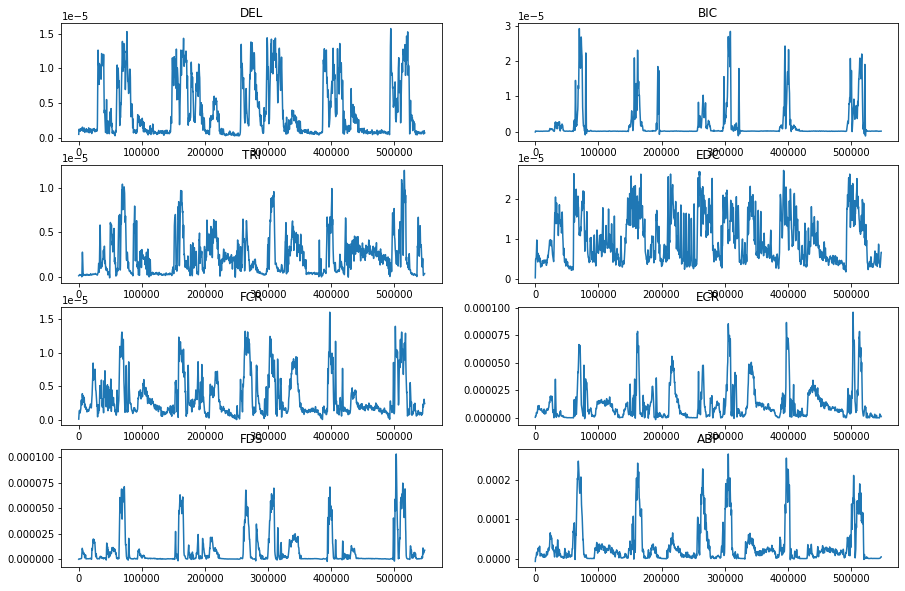

In [ ]:
plt.figure(figsize=(15,10))
for m in range(EMGenv.shape[1]):
        plt.subplot(4,2,m+1)
        plt.plot(EMGenv[:,m])
        #plt.legend(('raw EMG'), loc = 'upper right')
        plt.title(str(labels[m]))
plt.rcParams.update({'font.size': 10})

# Forecasting a Time Series

In one of her lectures, Sara learned that part of this dataset should be used as a training dataset to train a machine learning model of her choice to predict the muscular signals based on the neural signals. She almost started to select random samples for this purpose that were, if possible, representative of the overall course of the signals. She would also have taken care to use the same indices each time she ran the code, so as to create a stable training set. 

However, since she is not working on a **classification problem**, but on a **time series regression** task, she decides to use a fairer approach to determine the training, testing and validation set. 

## 1st approach: LSTM decoder
Sara already knows the basics about **Recurrent Neural Network (RNN)** architectures. Furthermore, she knows, that it is quite common to stack multiple layers of cells, which creates a *deep RNN*. She therefore definitely wants to use such a model. 

However, her neuroscience friend points out the **Short-Term Memory Problem**: As the data passes through the different layers of the network, it is continuously subjected to transformations. Consequently, at each stage, some information is eventually lost. After a while, the RNN is in a state where the data that was first added to the network has been discarded. 
To address this problem, different types of cells have been developed that possess long-term memory. One very popular variant is **Long Short-Term Memory (LSTM)** cells. 

In [ ]:
#%%Test decoding performance using Cross Validation
bins_before = 20
bins_after  = 20
R2_lstm     = []
rho2_lstm   = []
best_params = []

### Feature scaling









In [ ]:
##Load previously saved best parameters

# raw=true is important so you download the file rather than the webpage.
!wget https://github.com/christopherhitz/decoderproject/raw/main/src/models/best_params.pckl?raw=true
    
# Load the data
from scipy import io
!mv best_params.pckl\?raw\=true best_params.pckl
from scipy import io
#f = io.loadmat('best_params.pckl')

f = open('best_params.pckl','rb')
best_params = pickle.load(f)
f.close()

--2021-04-29 11:16:38--  https://github.com/christopherhitz/decoderproject/raw/main/src/models/best_params.pckl?raw=true
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/christopherhitz/decoderproject/main/src/models/best_params.pckl [following]
--2021-04-29 11:16:39--  https://raw.githubusercontent.com/christopherhitz/decoderproject/main/src/models/best_params.pckl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167 [application/octet-stream]
Saving to: ‘best_params.pckl?raw=true’

best_params.pckl?ra 100%[===================>]     167  --.-KB/s    in 0s      

2021-04-29 11:16:39 (5.82 MB/s) - 

In [ ]:
best_params

[{'dropout': 0.0976, 'lr': 0.0001, 'units': 125.6684},
 {'dropout': 0.2, 'lr': 0.003, 'units': 50},
 {'dropout': 0.2, 'lr': 0.003, 'units': 103.4186},
 {'dropout': 0, 'lr': 0.0001, 'units': 147.6746}]

Sara takes her brain and muscle data, and separates them into a training set to train the LSTM decoder. 

In [ ]:
#####################GET TRAINING DATA GIVEN THE PARTITION#####################
def getTrSet(alist, ts_val_ind = None):
    """
    Function that takes the list of trials and returns the training set for
    Cross Validation
    
    Inputs
    -------
    alist  : List in which data from trials are stored. Every element of the list
             has time on rows and neurons or muscles on columns
    ts_ind : Index of the element in the list that is the TEST set for the 
             current partition. Default = None says that all alist is taken as
             training set
             
    Output
    -------
    TrSet  : The Training Set with time on rows and neurons or muscles on
             columns
    """
    #Get the size of the output and initialize it
    if not isinstance(ts_val_ind,list):
        t = [alist[k].shape[0] for k in range(len(alist)) if k!=ts_val_ind]
    else:
        t = [alist[k].shape[0] for k in range(len(alist)) if (k!=ts_val_ind[0] and k!=ts_val_ind[1])]
    T     = sum(t)
    TrSet = np.zeros((T,alist[0].shape[1])) 
    
    #Fill TrSet
    k = 0
    for tr in range(len(alist)):
        if not isinstance(ts_val_ind,list):
            if tr == ts_val_ind:
                continue
        else:
            if tr == ts_val_ind[0] or tr == ts_val_ind[1]:
                continue
        r_end = k + alist[tr].shape[0]
        TrSet[k:r_end,:] = alist[tr]
        k = r_end
        
    return TrSet    


Before the LSTM network can be deployed, Sara transforms her training, testing and validation data into the shape that the network can handle.



In [ ]:
#########################FORMAT INPUT NEURAL NETWORKS##########################
def input_NN(Z, bins_before, bins_after):
    """
    Function that formats the Firing Rate matrix for the neural networks
    
    Inputs
    -------
    Z           : Matrix of binned Firing Rates (bins on rows and neurons on 
                  columns)
    bins_before : Number of bins preceding the current time step to give as 
                  input to the decoder
    bins_after  : Number of bins following the current time step to give as 
                  input to the decoder
    
    Output
    -------
    Zformat : Input for the NNs. 3D numpy array with dimensions
              [n_samples, nBins, n_neurons]
    """
    nBins   = bins_before + bins_after + 1 #The current time bin is always included
    Zformat = np.zeros([Z.shape[0]-nBins+1, nBins, Z.shape[1]])
    for k in range(Zformat.shape[0]):
        Zformat[k,:,:] = Z[k:k+nBins,:]
    
    return Zformat

Now, she designs a class for the LSTM decoder and builds the network architecture, ans sete the hyperparameters.

In [ ]:
#################### LONG SHORT TERM MEMORY (LSTM) DECODER ####################
class LSTMDecoder():
    """
    Class for the gated recurrent unit (GRU) decoder
    Parameters
    ----------
    units      : integer, optional, default 400
        Number of hidden units in each layer
    dropout    : decimal, optional, default 0
        Proportion of units that get dropped out
    num_epochs : integer, optional, default 10
        Number of epochs used for training
    verbose    : binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """
    def __init__(self, units = 128, dropout = 0, rec_dropout = 0, num_epochs = 20, lr = 0.001, batch_size = 64, poly = True, verbose=1):
         self.units       = units
         self.dropout     = dropout         
         self.rec_dropout = rec_dropout
         self.num_epochs  = num_epochs         
         self.lr          = lr
         self.batch_size  = batch_size
         self.verbose     = verbose
         self.poly        = poly

    def fit(self, X_train, y_train, validation_data = None, patience = 5):
        """
        Train LSTM Decoder
        Parameters
        ----------
        X_train : numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data.
            See example file for an example of how to format the neural data correctly
        y_train : numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        #Declare model
        model = Sequential() 
        #Add recurrent layer
        model.add(LSTM(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),
                       dropout=self.dropout,recurrent_dropout=self.rec_dropout)) #Within recurrent layer, include dropout
        if self.dropout!=0: 
            model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)
        #Add dense connections to output layer
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        #Fit model (and set fitting parameters)
        model.compile(loss='mae',optimizer=kopt.RMSprop(lr = self.lr),metrics=['accuracy']) #Set loss function and optimizer
        model.fit(X_train,y_train,epochs=self.num_epochs,batch_size=self.batch_size,
                  verbose=self.verbose,validation_data=validation_data,
                  callbacks=[callbacks.EarlyStopping(patience=patience)]) #Fit the model
        #Fit the polynomial
        y_out   = model.predict(X_train)
        y_out   = np.array(y_out)
        y_train = np.array(y_train)
        if self.poly:
            p = []
            for k in range(y_out.shape[1]):
                p = p + [np.polyfit(np.squeeze(y_out[:,k]), y_train[:,k], 5)]
            self.p = p
        self.model = model

    def predict(self, X_test):
        """
        Predict outcomes using trained LSTM Decoder
        Parameters
        ----------
        X_test : numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data being used to predict outputs.
        Returns
        -------
        y_test_predicted : numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """
        y_out = self.model.predict(X_test) #Make predictions
        #Apply the polynomial
        y_out = np.array(y_out)
        if self.poly:
            y_predict = []
            for k in range(y_out.shape[1]):
                y_predict = y_predict + [np.polyval(self.p[k], np.squeeze(y_out[:,k]))]
            return np.array(y_predict).T
        else:
            return y_out

### Measure the models' performance
To measure the models' accuracy, Sara wants to use the standard **root-mean-square error (RMSE)** and **Pearson correlation coefficient**. 




In [ ]:
def get_R2(y_test,y_test_pred):

    """
    Function to get R2

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    R2_array: An array of R2s for each output
    """

    R2_list=[] #Initialize a list that will contain the R2s for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute R2 for each output
        y_mean=np.mean(y_test[:,i])
        R2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        R2_list.append(R2) #Append R2 of this output to the list
    R2_array=np.array(R2_list)
    return R2_array #Return an array of R2s


In [ ]:
def get_rho2(y_test,y_test_pred):

    """
    Function to get Pearson's correlation (rho)

    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)

    Returns
    -------
    rho_array: An array of rho's for each output
    """

    rho_list=[] #Initialize a list that will contain the rhos for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute rho for each output
        y_mean=np.mean(y_test[:,i])
        rho=np.corrcoef(y_test[:,i].T,y_test_pred[:,i].T)[0,1]
        rho_list.append(rho) #Append rho of this output to the list
    rho_array=np.array(rho_list)
    return rho_array**2 #Return the array of rhos

In [ ]:
Neural = FRmat.copy()
EMG = EMGbin.copy()

Sara remembers that machine learning algorithms often don't work very well when the data has different scaling. She knows two methods that allow all attributes to have the same scale: The **min-max scaling (normalisation)** and **standardisation**. 
She decides that all muscular values should be between 0 and 1 and therefore chooses normalisation.  




Fold 1 of 4...

Epoch 1/100
113/113 [==============================] - 17s 123ms/step - loss: 0.1058 - accuracy: 0.4035 - val_loss: 0.0899 - val_accuracy: 0.3024
Epoch 2/100
113/113 [==============================] - 9s 80ms/step - loss: 0.0598 - accuracy: 0.5412 - val_loss: 0.0819 - val_accuracy: 0.3233
Epoch 3/100
113/113 [==============================] - 9s 80ms/step - loss: 0.0520 - accuracy: 0.5988 - val_loss: 0.0970 - val_accuracy: 0.3285
Epoch 4/100
113/113 [==============================] - 9s 80ms/step - loss: 0.0482 - accuracy: 0.6312 - val_loss: 0.1034 - val_accuracy: 0.3389
Epoch 5/100
113/113 [==============================] - 9s 81ms/step - loss: 0.0451 - accuracy: 0.6560 - val_loss: 0.0772 - val_accuracy: 0.3670
Epoch 6/100
113/113 [==============================] - 9s 80ms/step - loss: 0.0409 - accuracy: 0.6846 - val_loss: 0.0772 - val_accuracy: 0.4202
Epoch 7/100
113/113 [==============================] - 9s 80ms/step - loss: 0.0394 - accuracy: 0.6984 - val_loss: 0.0

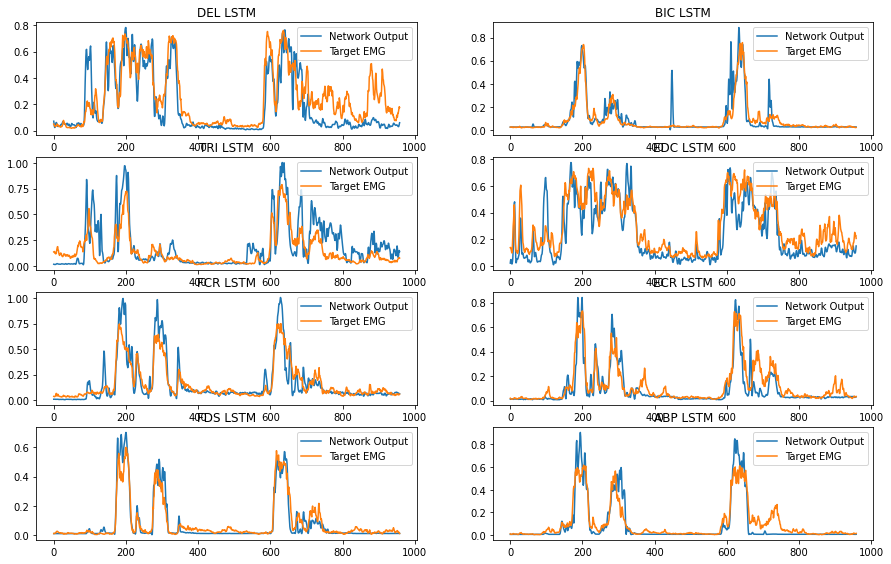

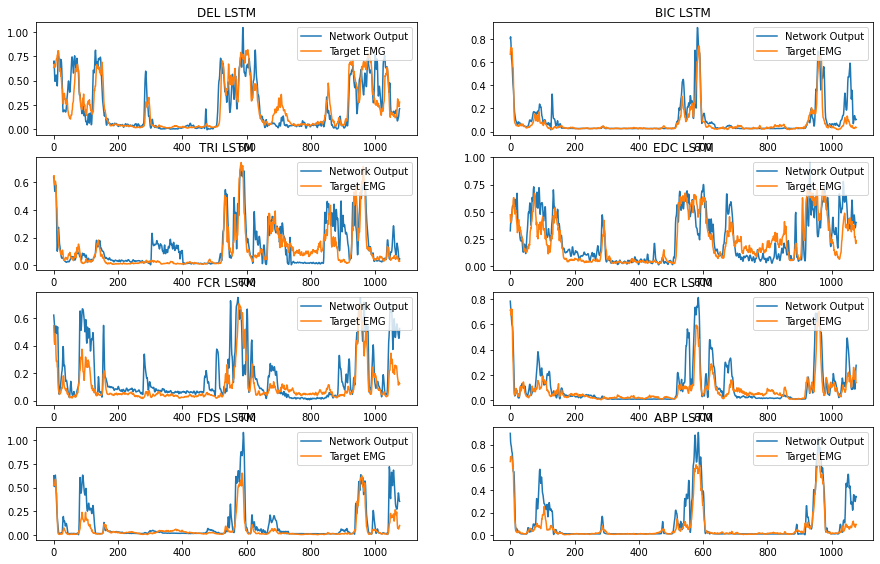

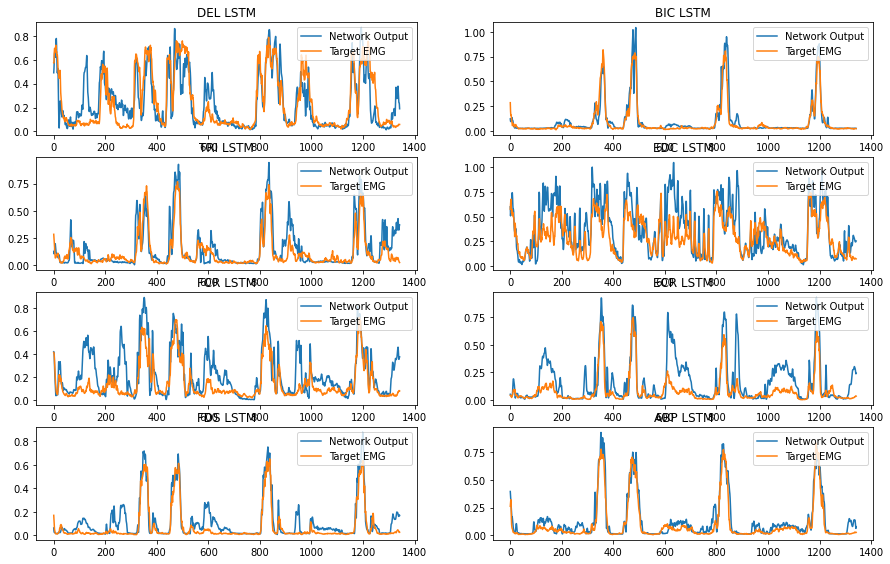

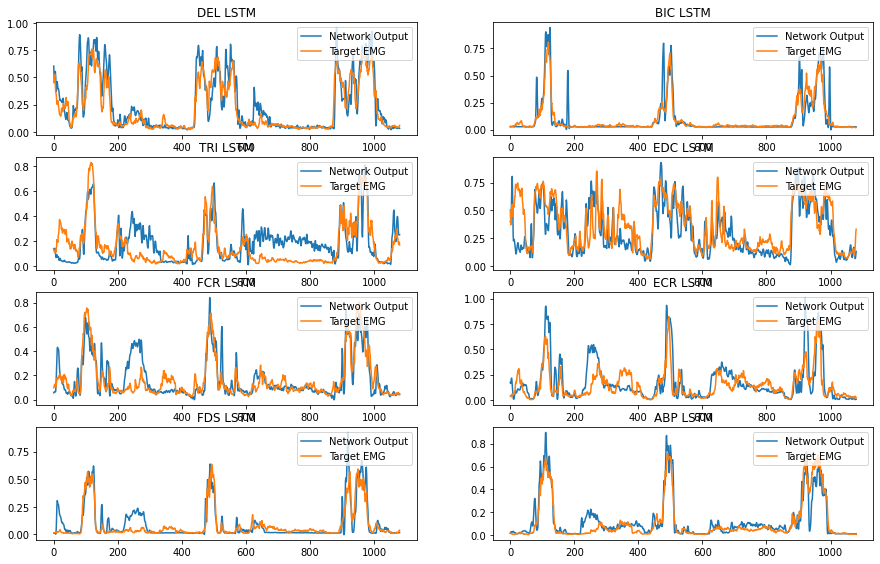

In [ ]:
for ts_val_ind in range(len(EMGbin)):
    print('\nFold '+str(ts_val_ind+1)+' of '+str(len(EMGbin))+'...\n')
    
    #Divide the dataset in training, validation and test set
    Z_tr       = getTrSet(FRmat, ts_val_ind)
    Z_val      = FRmat[ts_val_ind][:int(FRmat[ts_val_ind].shape[0]/2),:] #The val set is the 1st half of the trial indicated by ts_val_ind
    Z_ts       = FRmat[ts_val_ind][-int(FRmat[ts_val_ind].shape[0]/2):,:] #The test set is the 2nd half of the trial indicated by ts_val_ind
    X_tr       = getTrSet(EMGbin, ts_val_ind)
    X_val      = EMGbin[ts_val_ind][:int(FRmat[ts_val_ind].shape[0]/2),:] #The val set is the 1st half of the trial indicated by ts_val_ind
    X_ts       = EMGbin[ts_val_ind][-int(FRmat[ts_val_ind].shape[0]/2):,:] #The test set is the 2nd half of the trial indicated by ts_val_ind
        
    #Normalize outputs
    Xmin       = np.min(X_tr,axis=0)
    Xmax       = np.max(X_tr,axis=0)
    X_tr       = (X_tr-Xmin)/(Xmax-Xmin)
    X_val      = (X_val-Xmin)/(Xmax-Xmin)
    X_ts       = (X_ts-Xmin)/(Xmax-Xmin)
    
    #Format data for Neural Networks
    Z_tr        = input_NN(Z_tr, bins_before, bins_after)
    Z_ts        = input_NN(Z_ts, bins_before, bins_after)
    Z_val       = input_NN(Z_val, bins_before, bins_after)
    X_tr        = X_tr[bins_before:X_tr.shape[0]-bins_after,:]
    X_ts        = X_ts[bins_before:X_ts.shape[0]-bins_after,:]
    X_val       = X_val[bins_before:X_val.shape[0]-bins_after,:]

    units       = 128
    dropout     = 0
    lr          = 0.001
        
    #LSTM Network with Bayesian Optimization (uncomment below if you want to do bayesian optimization)
    # def lstm_evaluate(units, dropout, lr): #Function that evaluates the network for the given hyperparameters
    #    units       = int(units)
    #    dropout     = float(dropout)
    #    lr          = float(lr)
       
    #    lstm  = LSTMDecoder(units=units, dropout=dropout, lr=lr, num_epochs = 10, verbose=0, poly = False)
    #    lstm.fit(Z_tr, X_tr)
    #    X_out = lstm.predict(Z_val)
       
    #    return np.mean(get_R2(X_val, X_out))
   
    # BO = BayesianOptimization(lstm_evaluate, {'units': (50, 150), 'dropout': (0, 0.2), 'lr': (0.0001, 0.003)}, verbose = 1)
    # BO.maximize(init_points = 20, n_iter = 20)
    # best_params = best_params + [BO.res['max']['max_params']]
        

        
    lstm       = LSTMDecoder(units=units, dropout=dropout, lr=lr, num_epochs = 100, poly = False)
    lstm.fit(Z_tr, X_tr, validation_data = (Z_val, X_val), patience = 5)
    X_out_lstm = lstm.predict(Z_ts)
    R2_lstm    = R2_lstm + [get_R2(X_ts, X_out_lstm)]
    rho2_lstm  = rho2_lstm + [get_rho2(X_ts, X_out_lstm)]
    print('\nR2 = ' + str(R2_lstm[ts_val_ind]))

    plt.figure(figsize=(15,12))
    for m in range(X_ts.shape[1]):
        plt.subplot(5,2,m+1)
        plt.plot(X_ts[:,m])
        plt.plot(X_out_lstm[:,m])
        plt.legend(('Network Output','Target EMG'), loc = 'upper right')
        plt.title(str(labels[m]) + ' LSTM')
    plt.rcParams.update({'font.size': 10})
    
        
    #del units, dropout, lr, lstm, Z_tr, X_tr, Z_val, X_val, X_out_lstm

In [ ]:
#%%Print mean (across folds) rho2 and R2
print('\n\nLSTM \n'+'-'*20)
print('\nrho2 = ' + str(np.mean(rho2_lstm, axis = 0)))
print('\nR2 = ' + str(np.mean(R2_lstm, axis = 0)))



LSTM 
--------------------

rho2 = [0.73068952 0.78854224 0.62355198 0.65763344 0.66328184 0.67374791
 0.80808379 0.848685  ]

R2 = [0.68306284 0.77926308 0.53636561 0.57882266 0.57572837 0.60218566
 0.7668433  0.81832051]


From the graphs, the models performance does look quite nice. Well, the error measures tell a slightly different story. Therefore Sara decides to find better values for the networks hyperparameters by using a Bayesian Optimization with cross validation. But, of course, she can drink many coffees, while the optimization is running...

### Save the best parameters for each fold
Finally, she can save the best hyperparameter values, to be able to use them if she applys the model to new data in the future.

In [ ]:
#%%Save the best parameters for each fold
f2 = open('best_params.pckl', 'wb')
pickle.dump(best_params, f2)
f2.close()

## 2nd approach: Simple RNN - Go from Offline to Online Decoding
So far, Sara is very happy: She hard-coded the model to some extend on her own and she can predict (or replicate) the muscular signals pretty well-ish. 

But there's one drawback in her approach. Can you find it? Yes, she was developing an **offline decoder**. It would be better, if the model receives live brain data, and uses them to predict the muscle activity for some time steps ahead! This is what neuroscientists call an **real-time online decoder**. 
Therefore, Sara decides to design a simplified version using a **simple RNN** architecture. 

She further decides to only work on a *univariate time series*. Therefore, she wants to forecast the activity of one specific muscle from brain data. 

In [ ]:
Neural = FRmat.copy()
EMG = EMGbin.copy()

To beginn with, Sara combines all her neural and muscle data from the four training sessions in in long signal. Then, she subdivides them into short samples. Where each sample represents one reachin segment.
She assigns consecutive segments for training, testing, validation, and prediction sets for her RNN decoder.

In [ ]:
n_steps=50

EMGdata = np.concatenate((EMG[0], EMG[1], EMG[2], EMG[3]), axis=0)
EMGdata = EMGdata[:,4]

def generate_time_series(iterable, n_steps=1):
    l = len(iterable)
    for ndx in range(0, l, n_steps):
        yield iterable[ndx:min(ndx + n_steps, l)]

seriesEMG = []
for x in generate_time_series(EMGdata, n_steps + 10):
    seriesEMG.append(x)
seriesEMG=np.stack(seriesEMG[0:-1])
seriesEMG = seriesEMG[..., np.newaxis].astype(np.float32)


NEUROdata = np.concatenate((Neural[0], Neural[1], Neural[2], Neural[3]), axis=0)
NEUROdata = NEUROdata[:,4]

seriesNEURO = []
for x in generate_time_series(NEUROdata, n_steps + 10):
    seriesNEURO.append(x)
seriesNEURO=np.stack(seriesNEURO[0:-1])
seriesNEURO = seriesNEURO[..., np.newaxis].astype(np.float32)


X_train, y_train = seriesNEURO[:50, :n_steps], seriesEMG[:50, -10:, 0]
X_valid, y_valid = seriesNEURO[50:80, :n_steps], seriesEMG[50:80, -10:, 0]
X_test, y_test = seriesNEURO[80:130, :n_steps], seriesEMG[80:130, -10:, 0]

In [ ]:
Y = np.empty((154, n_steps, 10))
for step_ahead in range(1, 10 +1):
  Y[:, :, step_ahead - 1] = seriesEMG[:, step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:50]
Y_valid = Y[50:80]
Y_test = Y[80:130]  

Then she designs her very simple RNN network. She keeps it easy, because she can't drink many coffees anymore.

In [ ]:
from tensorflow import keras
model = keras.models.Sequential([
                                 keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.TimeDistributed(keras.layers.Dense(10)),
])

Her network structure can be summarized as follows:

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
time_distributed (TimeDistri (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


Then, Sara decides on a performance measure, and chooses an adapted RMSE approach. Additional, she chooses a standard optimizer and learning rate.

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
  return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(lr=0.01)  

She compiles the model:

In [ ]:
model.compile(loss='mse',
              optimizer=optimizer,
              metrics=[last_time_step_mse]
              )

As a next step, Sara fits the model to her training set to find good values for the models parameters.

In [ ]:
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
2/2 [==============================] - 2s 411ms/step - loss: 0.6323 - last_time_step_mse: 0.6165 - val_loss: 0.1803 - val_last_time_step_mse: 0.1836
Epoch 2/20
2/2 [==============================] - 0s 83ms/step - loss: 0.1719 - last_time_step_mse: 0.1839 - val_loss: 0.1047 - val_last_time_step_mse: 0.0984
Epoch 3/20
2/2 [==============================] - 0s 65ms/step - loss: 0.1013 - last_time_step_mse: 0.0998 - val_loss: 0.0744 - val_last_time_step_mse: 0.0685
Epoch 4/20
2/2 [==============================] - 0s 67ms/step - loss: 0.0712 - last_time_step_mse: 0.0736 - val_loss: 0.0542 - val_last_time_step_mse: 0.0505
Epoch 5/20
2/2 [==============================] - 0s 68ms/step - loss: 0.0516 - last_time_step_mse: 0.0561 - val_loss: 0.0448 - val_last_time_step_mse: 0.0421
Epoch 6/20
2/2 [==============================] - 0s 67ms/step - loss: 0.0425 - last_time_step_mse: 0.0472 - val_loss: 0.0342 - val_last_time_step_mse: 0.0304
Epoch 7/20
2/2 [=============================

Sara trains the model to forecast the next 10 values at each and every time step (**sequence-to-sequence RNN**): At time step 0 the model will output a vector containing the forecasts for time steps 1 to 10, then at time step 1 the model will forecast time steps 2 to 11, and so on. So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Sara prepares the target sequence by first combining all her 4 training sessions together.

In [ ]:
history.params

{'epochs': 20, 'steps': 2, 'verbose': 1}

In [ ]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
history.history

{'last_time_step_mse': [0.5544675588607788,
  0.17502360045909882,
  0.09934444725513458,
  0.07111392170190811,
  0.054102689027786255,
  0.04562791436910629,
  0.033759329468011856,
  0.02269967645406723,
  0.018107658252120018,
  0.014456613920629025,
  0.010359635576605797,
  0.007083200383931398,
  0.006736214738339186,
  0.006300586275756359,
  0.004575901199132204,
  0.0032858229242265224,
  0.0028947382234036922,
  0.0027807822916656733,
  0.002346472116187215,
  0.0018883416196331382],
 'loss': [0.5685765147209167,
  0.1651349663734436,
  0.1000758707523346,
  0.06968165189027786,
  0.0508589968085289,
  0.04170387238264084,
  0.031377650797367096,
  0.022824954241514206,
  0.01909344643354416,
  0.01590183936059475,
  0.011510896496474743,
  0.0081593357026577,
  0.007929964922368526,
  0.00743725523352623,
  0.005512099713087082,
  0.004257664550095797,
  0.0039705997332930565,
  0.003776016179472208,
  0.0032961710821837187,
  0.0027018149849027395],
 'val_last_time_step_ms

At the end, Sara wants to have an graphical overview of the performance of the Simple RNN model. It looks to good to be true. Especially, when Sara remembers to shift the loss functions one sample to the left. But she will work on the sources of this in the future.

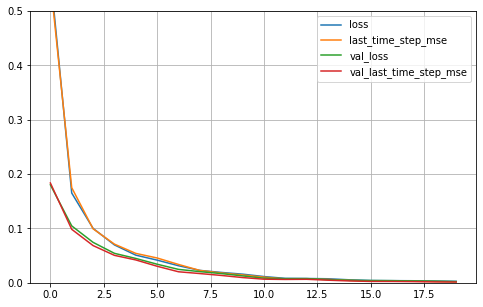

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 0.5)
plt.show()

So far, Sara is very happy what she has achieved in a short amount of time, and is happy to continueing to create better models and to deploy them.

